### Analysis
Import, clean, and process the data

In [138]:
import copy
import datetime
import helper
import numpy as np
import os
import pandas as pd


# All files from teslamotorsinc-my.sharepoint.com are placed under energy_data
# in this project. These files are provided seprately.
DATA_FILE_LOCATION = os.path.join(os.getcwd(), "energy_data")
OUTPUT_FILE_LOCATION = os.path.join(os.getcwd(), "analysis_results")

In [45]:
# Gather data filenames for import from the file system
signal_filenames = [f for f in os.listdir(DATA_FILE_LOCATION) if "signals_data" in f]
alert_filenames = [f for f in os.listdir(DATA_FILE_LOCATION) if "alerts_data" in f]

if len(signal_filenames)==0 or len(alert_filenames)==0:
    raise Exception("ERROR: CSV data files were not found. These should be added under /energy_data")

# Import signals and alerts from all the files into dataframes.
# There is not much data so this should be okay
# Otherwise I would tackle this day by day, as pandas is all in-memory
signal_df = helper.import_csv_files(DATA_FILE_LOCATION, signal_filenames)
alert_df = helper.import_csv_files(DATA_FILE_LOCATION, alert_filenames)

# Also clean the signal data for unrealistic temperatures as explained in input_validation.ipynb
# signal_df = helper.clean_temperature_data(signal_df)

# Datetime convert the raw timestamp
signal_df["datetime_timestamp"] = pd.to_datetime(
    signal_df['timestamp'], unit='ms'
)

# Add datetime to the alert data as well
alert_df["datetime_timestamp"] = pd.to_datetime(
    alert_df['timestamp'], unit='ms'
)

### Challenge #1 and #2
**1. Using the signals_data files, provide a list of components that have an average temeprature above 105 degrees during any 30 second period. Perform this analysis for all temperature signals in the dataset.**

**2. Provide the maximum power (given by the LM_PowerLimit signal) that occurs during any 30 second period when a component experiences an average temperature of 105 degrees over that period.**

It doesn't make much sense to me to choose arbitrary 30 second time periods, like we might do with hourly or daily aggregations. Depending on where we start it can change the results and specifically hide borderline events. So I will instead do rolling calculations with a sliding window of 30 seconds.

The signal data appears to be time synchronized between connector pos/neg but other signals are never quite time aligned. Each signal appears to be on an approximately 10 second schedule, with LM_powerLimit slightly more random in timing. To compare signals I need to fill some data between time points. I will take the LM_handlePos/NegCoreTempDegC signals as the time base for analysis, and use interpolation for the other signals. I will then clear out the other measurements which are not time aligned with handle temperatures. To achieve the 30s rolling average I will then be able to use 3 sample trailing average, or, at least there won't be any funny weightings because I've added interpolated values.
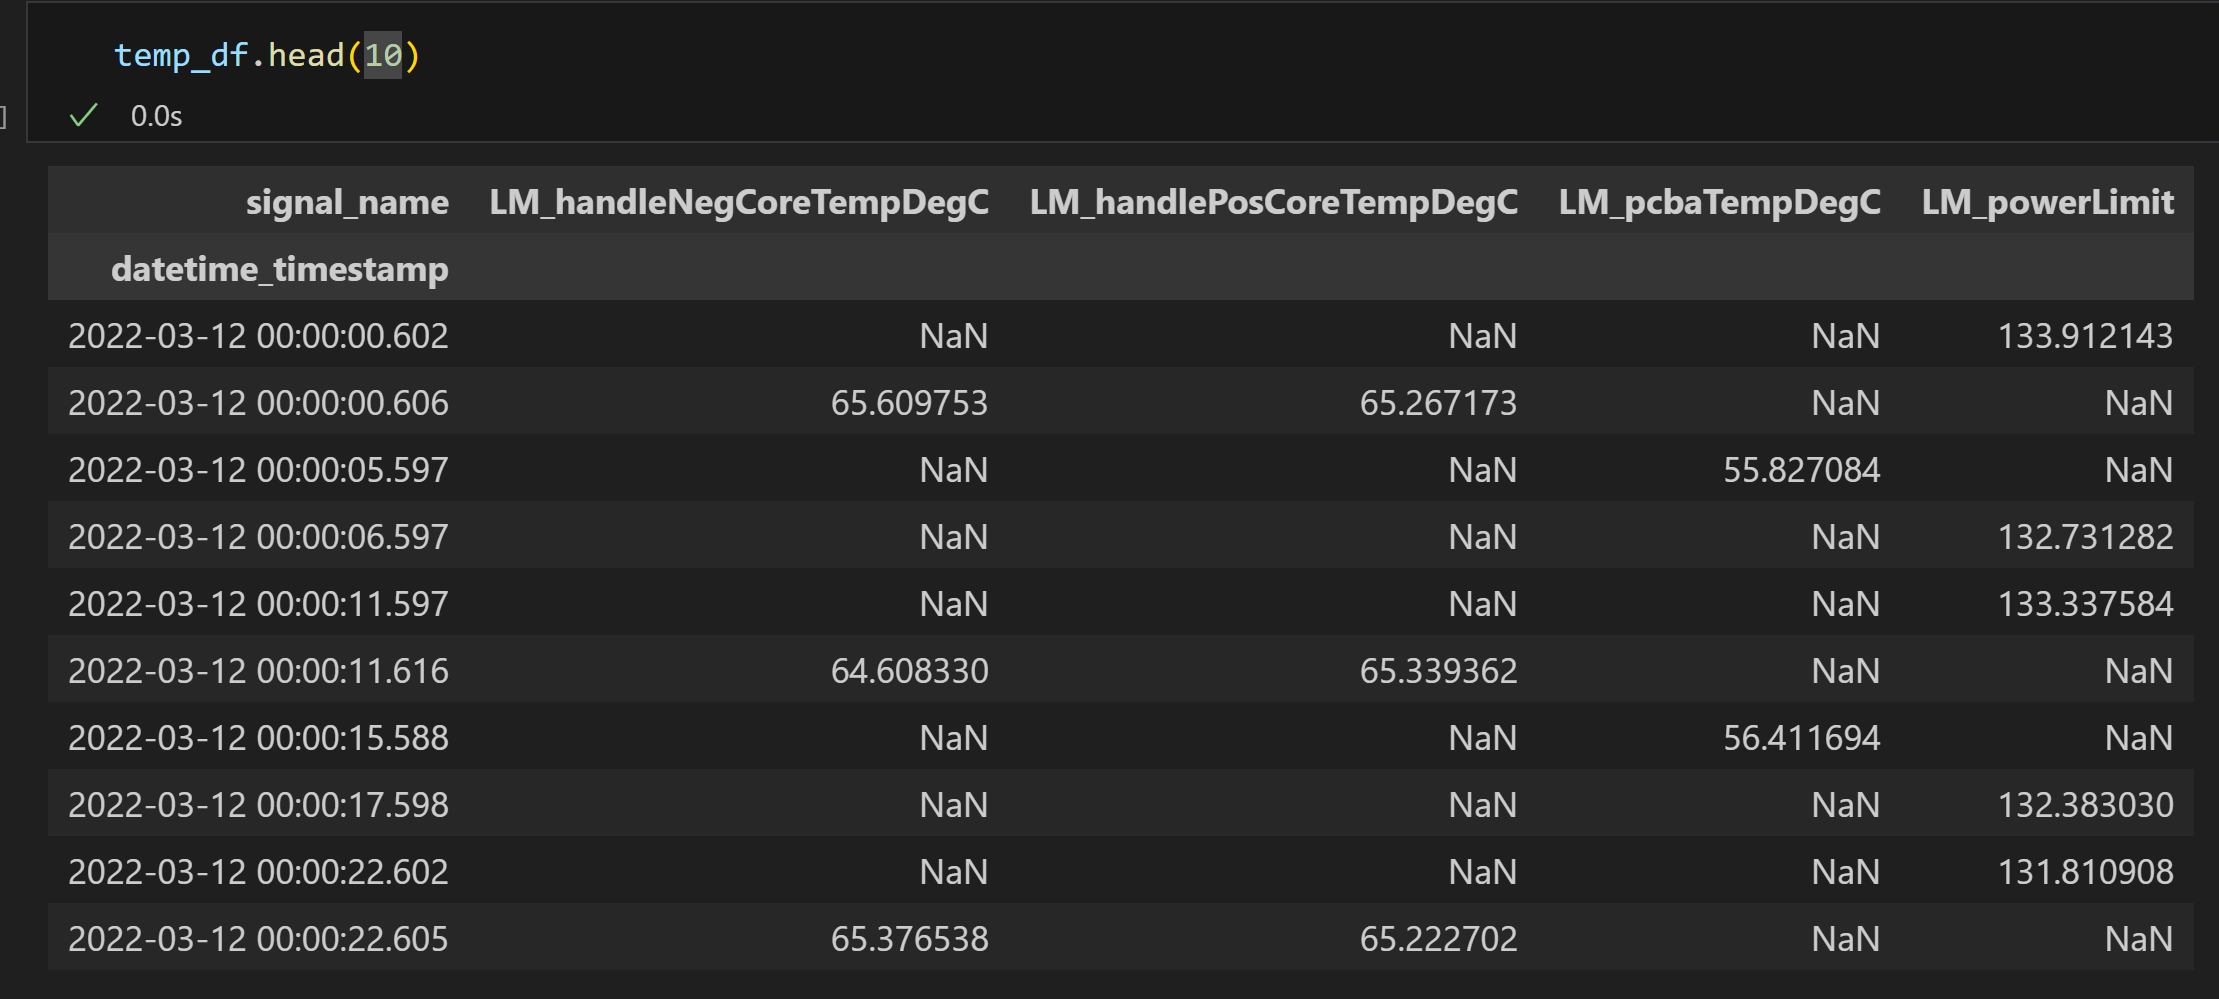

In [46]:
# Our temperature signals should be ['LM_handleNegCoreTempDegC', 'LM_handlePosCoreTempDegC', 'LM_pcbaTempDegC']
temperature_signals = [sig for sig in list(pd.unique(signal_df['signal_name'])) if "TempDegC" in sig]

# COMPONENT IDs appear to be unique across the system, so we won't bother to carry the SITE and ASSET through this evaluation as well
components = list(pd.unique(signal_df['COMPONENT']))

# Initialize a list of dictionaries to hold detected issues with some metrics
thermal_issues = []

for component in components:
    # Pivot is used here to get a column per signal
    temp_df = pd.pivot_table(signal_df[signal_df['COMPONENT']==component],
                             index='datetime_timestamp', 
                             columns=['signal_name'],
                             values='VALUE')
    
    # Now selectively interpolate forward for other signals
    for signal in ['LM_pcbaTempDegC', 'LM_powerLimit']:
        temp_df[signal] = temp_df[signal].interpolate()

    # And drop rows that don't line up with 'LM_handleNegCoreTempDegC', 'LM_handlePosCoreTempDegC'
    # It's also a good idea to drop_duplicates if there are any so we don't mess up rolling calculations
    temp_df = temp_df.dropna().drop_duplicates()

    # Calculate the rolling average going back 30s (should be 3 samples normally)
    for col in temperature_signals:
        temp_df[f"{col}_rolling_avg"] = temp_df[col].rolling(window='30s').mean()

    # We'll also need the max power over the window
    temp_df["LM_powerLimit_30s_max"] = temp_df["LM_powerLimit"].rolling(window='30s').max()

    # Now check each temperature signal for exceeding 105degC in the past 30s
    for col in temperature_signals:
        overages = temp_df[temp_df[f"{col}_rolling_avg"]>105.0]

        if len(overages.index):
            # This component and signal had some overages!
            print(f"component {component} {col} had some overages!")
            for index, row in overages.iterrows():
                thermal_issues.append({
                    "component": component,
                    "timestamp": index.timestamp(),
                    "signal_name": f"{col}_rolling_avg",
                    "signal_value": row[f"{col}_rolling_avg"],
                    "LM_powerLimit_30s_max": row["LM_powerLimit_30s_max"],
                    "comment": f"{col}_rolling_avg exceeded 105.0 degC"
                })

thermal_issues_df = pd.DataFrame.from_dict(thermal_issues)
thermal_issues_df.to_csv(os.path.join(OUTPUT_FILE_LOCATION, "thermal_signal_issues.csv"))

component 420204713 LM_handleNegCoreTempDegC had some overages!
component -1996083301 LM_handlePosCoreTempDegC had some overages!
component 1212935405 LM_handlePosCoreTempDegC had some overages!
component 399812473 LM_handleNegCoreTempDegC had some overages!
component 1396988257 LM_handleNegCoreTempDegC had some overages!


### Answer to #1 and #2
1. A list of components having any overtemperature are listed below
2. The maximum power from the 30s periods are given in `thermal_signal_issues.csv`

In [47]:
print("Components with any temperatures exceeding 105 degC average over 30s:")
print(list(pd.unique(thermal_issues_df['component'])))

Components with any temperatures exceeding 105 degC average over 30s:
[420204713, -1996083301, 1212935405, 399812473, 1396988257]


### Challenge #3
**Provide the average power and temperature when a temperature related alert fires (see alerts_data for the alerts information and timestamps). Detail your method for aligning the alert timestamps with the signal timestamps, and your method for determining the value of the signal that occurs when the alert fires.**

For this analysis I will insert alert data into the pivoted signal data. In order to get signal overlaps for timestamp, I will apply forward filling of signal data to line up with the alert timestamps. This selects the alert time base and looks at the last known signal values before that time.

This is simpler than making a new column for each alert and treating it as a boolean signal, but that's also a reasonable approach.

In [94]:
# This is helpful to insert an alert as a boolean signal
alert_df['VALUE'] = 1.0

all_alerts = list(pd.unique(alert_df['alert_name']))

temperature_alert_df_list = []

# Iterate through the components again like the prior questions
for component in components:
    # Pivot is used here to get a column per signal
    pivot_signal_df = pd.pivot_table(signal_df[signal_df['COMPONENT']==component],
                             index='datetime_timestamp', 
                             columns=['signal_name'],
                             values='VALUE')    
    
    # alerts are already in a useful format for what we need
    modified_alert_df = (
        alert_df[alert_df['COMPONENT']==component][['datetime_timestamp', 'alert_name']]
        .set_index('datetime_timestamp')
    )
    
    combined_pivot_df = pivot_signal_df.merge(modified_alert_df, how='outer', left_index=True, right_index=True)
    # Now selectively interpolate forward for other signals
    for signal in ['LM_handleNegCoreTempDegC', 'LM_handlePosCoreTempDegC', 'LM_pcbaTempDegC', 'LM_powerLimit']:
        combined_pivot_df[signal] = combined_pivot_df[signal].ffill()

    # And drop rows that don't line up with 'LM_handleNegCoreTempDegC', 'LM_handlePosCoreTempDegC'
    # It's also a good idea to drop_duplicates if there are any so we don't mess up rolling calculations
    combined_pivot_df = combined_pivot_df.dropna().drop_duplicates()

    # adding the component here for traceability, and get a numeric index so we can easily concat many of these together
    combined_pivot_df.insert(loc=0, column='component', value=component)
    combined_pivot_df = combined_pivot_df.reset_index()

    temperature_alert_df_list.append(copy.deepcopy(combined_pivot_df))

temperature_alert_df = pd.concat(temperature_alert_df_list).reset_index(drop=True)
temperature_alert_df.to_csv(os.path.join(OUTPUT_FILE_LOCATION, "temperature_alerts_data.csv"))


In [93]:
temperature_alert_df

,datetime_timestamp,component,LM_handleNegCoreTempDegC,LM_handlePosCoreTempDegC,LM_pcbaTempDegC,LM_powerLimit,alert_name
0,2022-03-19 03:53:55.659,420204713,96.275534,76.151024,55.929197,283.922876,LM_a141_cableTempImbalance
1,2022-03-19 03:56:14.456,420204713,101.675034,81.380908,56.356570,263.082123,LM_a141_cableTempImbalance
2,2022-03-14 21:05:48.184,252179273,58.452676,45.344503,57.642230,106.643328,LM_a141_cableTempImbalance
3,2022-03-15 16:24:11.777,252179273,59.347967,38.872850,51.559220,105.772355,LM_a141_cableTempImbalance
4,2022-03-15 19:48:04.143,252179273,55.024503,41.315805,55.269168,191.911695,LM_a141_cableTempImbalance
...,...,...,...,...,...,...,...
192,2022-03-16 21:52:09.839,1105510009,40.290676,41.180831,44.294198,46.498393,LM_a247_ambientTempStale
193,2022-03-17 21:11:06.031,1105510009,71.073776,69.332726,52.620411,225.814186,LM_a247_ambientTempStale
194,2022-03-19 15:07:30.114,1105510009,52.156548,52.992305,55.082830,69.188412,LM_a247_ambientTempStale
195,2022-03-16 21:52:09.839,-404457910,43.346906,44.028058,44.568339,20.836466,LM_a247_ambientTempStale


### Answer to #3
1. The mean power and temperatures are calculated for the instances of each alert across the fleet

In [112]:
(temperature_alert_df[['LM_handleNegCoreTempDegC', 'LM_handlePosCoreTempDegC', 'LM_pcbaTempDegC', 'LM_powerLimit', 'alert_name']]
 .groupby('alert_name')
 .agg(['mean']))


,LM_handleNegCoreTempDegC,LM_handlePosCoreTempDegC,LM_pcbaTempDegC,LM_powerLimit
,mean,mean,mean,mean
alert_name,,,,
LM_a141_cableTempImbalance,40.320232,56.363304,50.604186,150.179202
LM_a188_negTempOT,37.204423,30.764500,39.247948,30.892347
LM_a191_negTempRationality,-51.750418,33.998214,41.260264,41.431111
LM_a243_negCoreTempHiFoldBk,75.452406,30.976360,39.477849,35.902905
LM_a247_ambientTempStale,48.780934,48.925554,48.882413,67.633125


### Challenge #4
**Create exploratory data visualizations that indicate the general power, temperature and alert trends of the sites, assets and components in the data. Additionally please provide visualizations that allow for items that are concerning and need investigation to be easily identified for further followup. The hypothetical audience for these visualizations would be engineering stakeholders who are looking to understand any trends or correlations in the provided signals / alerts that could indicate poorly performing equipment and possible causes. You can use any tool or platform you wish (Tableau is preferred) but please present the results with some explanations in the jupyter notebook submission. Please note that
providing an individual temperature graph for every asset, site and component does not achieve these goals.**

In order to use Tableau for the visualizations, I'll first process and export some additional metrics via this notebook, which can be imported in Tableau for display.

In [207]:
# Daily Aggregations

# Pull out the unique combinations of SITE, ASSET, COMPONENT for iteration
components = (signal_df[['SITE', 'ASSET', 'COMPONENT']]
              .groupby(['SITE', 'ASSET', 'COMPONENT']).size()
              .reset_index().drop(0)
)

# Establish a list of aggregations to be concatenated together later
daily_aggregations_list = []

for ix, component_row in components.iterrows():
    # print(f"{component_row['SITE']} {component_row['ASSET']} {component_row['COMPONENT']}")

    # Pivot is used here to get a column per signal, filtered on the triple of SITE, ASSET, COMPONENT
    temp_df = pd.pivot_table(signal_df[(signal_df['SITE']==component_row['SITE'])
                                       & (signal_df['ASSET']==component_row['ASSET'])
                                       & (signal_df['COMPONENT']==component_row['COMPONENT'])],
                             index='datetime_timestamp', 
                             columns=['signal_name'],
                             values='VALUE')
    
    # Now selectively interpolate forward for other signals
    for signal in ['LM_pcbaTempDegC', 'LM_powerLimit']:
        temp_df[signal] = temp_df[signal].interpolate()

    # And drop rows that don't line up with 'LM_handleNegCoreTempDegC', 'LM_handlePosCoreTempDegC'
    # It's also a good idea to drop_duplicates in case there are any double timestamped data
    temp_df = temp_df.dropna().drop_duplicates()

    # ***********************************************
    # Generate daily aggregation rows with this data
    # ***********************************************

    # Perform all the simple aggregations with agg()
    daily_aggregations = temp_df.groupby(temp_df.index.date).agg(
        LM_handleNegCoreTempDegC_min=('LM_handleNegCoreTempDegC', 'min'),
        LM_handleNegCoreTempDegC_avg=('LM_handleNegCoreTempDegC', 'mean'),
        LM_handleNegCoreTempDegC_max=('LM_handleNegCoreTempDegC', 'max'),

        LM_handlePosCoreTempDegC_min=('LM_handlePosCoreTempDegC', 'min'),
        LM_handlePosCoreTempDegC_avg=('LM_handlePosCoreTempDegC', 'mean'),
        LM_handlePosCoreTempDegC_max=('LM_handlePosCoreTempDegC', 'max'),

        LM_pcbaTempDegC_min=('LM_pcbaTempDegC', 'min'),
        LM_pcbaTempDegC_avg=('LM_pcbaTempDegC', 'mean'),
        LM_pcbaTempDegC_max=('LM_pcbaTempDegC', 'max'),

        LM_powerLimit_avg=('LM_powerLimit', 'mean'),
        LM_powerLimit_max=('LM_powerLimit', 'max')
    )

    daily_aggregations.index.name = 'date'

    # Prefill the SITE/ASSET/COMPONENT so these aggregations can be combined and dropped into the same table
    daily_aggregations.insert(loc=0, column='component', value=component_row['COMPONENT'])
    daily_aggregations.insert(loc=0, column='asset', value=component_row['ASSET'])
    daily_aggregations.insert(loc=0, column='site', value=component_row['SITE'])

    # Add some more complex aggregations

    # ***********************************************
    # Estimate utilization per day by finding gaps in data greater than 30 seconds
    # Since we have several days of data we want to work on, insert midnight rows for each date to divide gaps by day
    # If we don't have all the data for the last day yet, it will appear under utilized.

    # Get all the data timestamps
    utilization = temp_df.index.to_list()

    # Get just prior to midnight timestamps for every date spanned by daily_aggregations df, add them in with the data timestamps
    min_date = min(daily_aggregations.index.to_list())
    max_date = max(daily_aggregations.index.to_list()) + datetime.timedelta(days=1)
    midnights = pd.date_range(start=min_date, end=max_date).to_series().to_list()
    midnights = [x-pd.Timedelta('1ms') for x in midnights]  # Use 1ms before, this is needed due to how diff() works
    utilizations = sorted(utilization + midnights)

    # Make a dataframe of timestamps using diff() to get timedeltas between samples on each side of midnights
    utilization_df = pd.DataFrame(utilizations, columns=['unused_duration'], index=pd.Index(utilizations, name='timestamp')).diff()

    # Filter out timedeltas less than or equal to 30 seconds
    non_utilization_df = utilization_df[utilization_df['unused_duration'] > pd.Timedelta('30s')]

    # Sum up the gaps in data per day and call it unused_duration
    estimated_utilization = non_utilization_df.groupby(non_utilization_df.index.date).sum()

    # Utilization should be (24h - unused_duration) / 24h
    estimated_utilization['estimated_utilization'] = (pd.Timedelta('24h') - estimated_utilization['unused_duration']) / pd.Timedelta('24h')

    # Finished with math now, convert this to integer seconds
    estimated_utilization['unused_duration'] = estimated_utilization['unused_duration'].map(lambda x: x.seconds)

    # Add estimated_utilization metrics to the daily_aggregations dataframe
    daily_aggregations = daily_aggregations.join(estimated_utilization)

    # ***********************************************
    # All aggregation metrics are complete for this component, save in a list
    daily_aggregations_list.append(daily_aggregations)

combined_daily_aggregations = pd.concat(daily_aggregations_list)
combined_daily_aggregations.to_csv(os.path.join(OUTPUT_FILE_LOCATION, 'daily_aggregations.csv'))


